## Importing libraries

In [44]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [46]:
from linkedin_api import Linkedin

## Calling linkedin api and getting user information

In [48]:
# Enter email password of linkedin account
api = Linkedin('email', 'password')

In [49]:
profile = api.get_profile('gaurav-shetty-3762a8150')
profile

{'summary': 'I am a results-driven data professional with a solid background in data science, solution architecture, and analytics, with a track record of implementing impactful solutions across industries such as telecom, energy, and e-commerce.\n\nAt Reliance Jio, India’s leading telecom provider, I worked as a Solution Architect, where I played a pivotal role in developing system architectures for on-demand SIM card activation and doorstep delivery through the Jio.com website and the MyJio app. My work streamlined customer acquisition processes while ensuring data privacy and operational efficiency. Additionally, I designed a versatile coupon management system that enhanced customer acquisition from competitors and continues to support diverse marketing campaigns. My expertise in troubleshooting led me to resolve complex production issues using XML, SOAP, REST APIs, and SQL.\n\nIn my internship at Philadelphia Gas Works, I applied my data science skills to build forecasting models a

## Initializing the datasets

In [75]:
data = pd.read_excel('project_data/oesm23nat/national_M2023_dl.xlsx')
data.head()

,AREA,AREA_TITLE,AREA_TYPE,PRIM_STATE,NAICS,NAICS_TITLE,I_GROUP,OWN_CODE,OCC_CODE,OCC_TITLE,...,H_MEDIAN,H_PCT75,H_PCT90,A_PCT10,A_PCT25,A_MEDIAN,A_PCT75,A_PCT90,ANNUAL,HOURLY
0,99,U.S.,1,US,0,Cross-industry,cross-industry,1235,00-0000,All Occupations,...,23.11,37.01,58.4,29050,35660,48060,76980,121470,NaN,NaN
1,99,U.S.,1,US,0,Cross-industry,cross-industry,1235,11-0000,Management Occupations,...,56.19,81.29,111.36,54550,78330,116880,169090,231620,NaN,NaN
2,99,U.S.,1,US,0,Cross-industry,cross-industry,1235,11-1000,Top Executives,...,49.74,79.57,#,46400,66170,103460,165500,#,NaN,NaN
3,99,U.S.,1,US,0,Cross-industry,cross-industry,1235,11-1010,Chief Executives,...,99.37,#,#,80000,130840,206680,#,#,NaN,NaN
4,99,U.S.,1,US,0,Cross-industry,cross-industry,1235,11-1011,Chief Executives,...,99.37,#,#,80000,130840,206680,#,#,NaN,NaN


In [54]:
data_2020 = pd.read_excel('project_data/oesm19nat/national_M2019_dl.xlsx')

In [56]:
ind_data_2033 = pd.read_excel('project_data/2023-33/industry.xlsx',sheet_name = 11,skiprows=1)
ind_data_2033.head()

,2023 National Employment Matrix title,2023 National Employment Matrix code,Industry type,"Employment, 2023","Employment, 2033","Employment change, numeric, 2023–33","Employment change, percent, 2023–33","Compound annual rate of change, employment, 2023–33","Output, 2023[1][2]","Output, 2033[1][2]","Compound annual rate of change, output, 2023–33"
0,Total employment,TE1000,Summary,167849.8,174589,6739.2,4,0.4,38771.3,46879.3,1.9
1,Self-employed workers,TE1100,Line item,9708.9,9828.8,119.9,1.2,0.1,–,–,–
2,Total wage and salary employment,TE1200,Summary,158140.9,164760.3,6619.3,4.2,0.4,–,–,–
3,"Agriculture, forestry, fishing and hunting",110000,Summary,1461.8,1473,11.2,0.8,0.1,443.6,509.7,1.4
4,Crop production,111000,Line item,849.3,874.4,25.1,3,0.3,171,192.7,1.2


## Finding occupations similar to the users industry

In [58]:
from transformers import AutoTokenizer, AutoModelForMaskedLM

tokenizer = AutoTokenizer.from_pretrained("jjzha/jobbert-base-cased")
model = AutoModelForMaskedLM.from_pretrained("jjzha/jobbert-base-cased")

In [59]:
from transformers import AutoTokenizer, AutoModel
import torch
from scipy.spatial.distance import cosine

# Load tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("jjzha/jobbert-base-cased")
model = AutoModel.from_pretrained("jjzha/jobbert-base-cased")

ind_title = profile['industryName']

# Tokenize and get embeddings for the industry title
ind_inputs = tokenizer(ind_title, return_tensors="pt", truncation=True, padding=True)
with torch.no_grad():
    ind_outputs = model(**ind_inputs)

# Define mean pooling function
def mean_pooling(token_embeddings, attention_mask):
    # Multiply token embeddings by their respective attention mask
    token_embeddings = token_embeddings * attention_mask.unsqueeze(-1)
    # Sum embeddings across the sequence dimension and divide by the attention mask sum
    return token_embeddings.sum(dim=1) / attention_mask.sum(dim=1).unsqueeze(-1)

# Compute the industry title embedding
ind_embedding = mean_pooling(ind_outputs.last_hidden_state, ind_inputs['attention_mask'])
ind_vector = ind_embedding.squeeze().cpu().numpy()

# List to store similarity scores and occupation titles
similarities = []

# Iterate through occupation titles and calculate similarity
for occ_title in data['OCC_TITLE']:
    # Tokenize inputs
    occ_inputs = tokenizer(occ_title, return_tensors="pt", truncation=True, padding=True)
    
    # Get embeddings from the model
    with torch.no_grad():
        occ_outputs = model(**occ_inputs)
    
    # Compute the occupation title embedding
    occ_embedding = mean_pooling(occ_outputs.last_hidden_state, occ_inputs['attention_mask'])
    occ_vector = occ_embedding.squeeze().cpu().numpy()
    
    # Compute cosine similarity
    similarity = 1 - cosine(ind_vector, occ_vector)
    
    # Store similarity and occupation title
    similarities.append((occ_title, similarity))


Some weights of BertModel were not initialized from the model checkpoint at jjzha/jobbert-base-cased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


In [61]:
# Sort by similarity in descending order and get the top 5
top_5_similar = sorted(similarities, key=lambda x: x[1], reverse=True)[:10]

# Print the top 5 results
print("Top 5 most similar occupations:")
for title, score in top_5_similar:
    print(f"{title}: {score:.4f}")

Top 5 most similar occupations:
Computer and Information Systems Managers: 0.6845
Computer and Information Systems Managers: 0.6845
Computer Network Architects: 0.6795
Information Security Analysts: 0.6748
Computer Network Support Specialists: 0.6669
Computer and Information Research Scientists: 0.6437
Computer and Information Research Scientists: 0.6437
Business Operations Specialists: 0.6409
Web and Digital Interface Designers: 0.6356
Network and Computer Systems Administrators: 0.6263


## Creating a visualization to compare salaries of different occupations 

Visualization Chart 1: 
Here is the mean hourly and annual salary for different occupations in your field: 


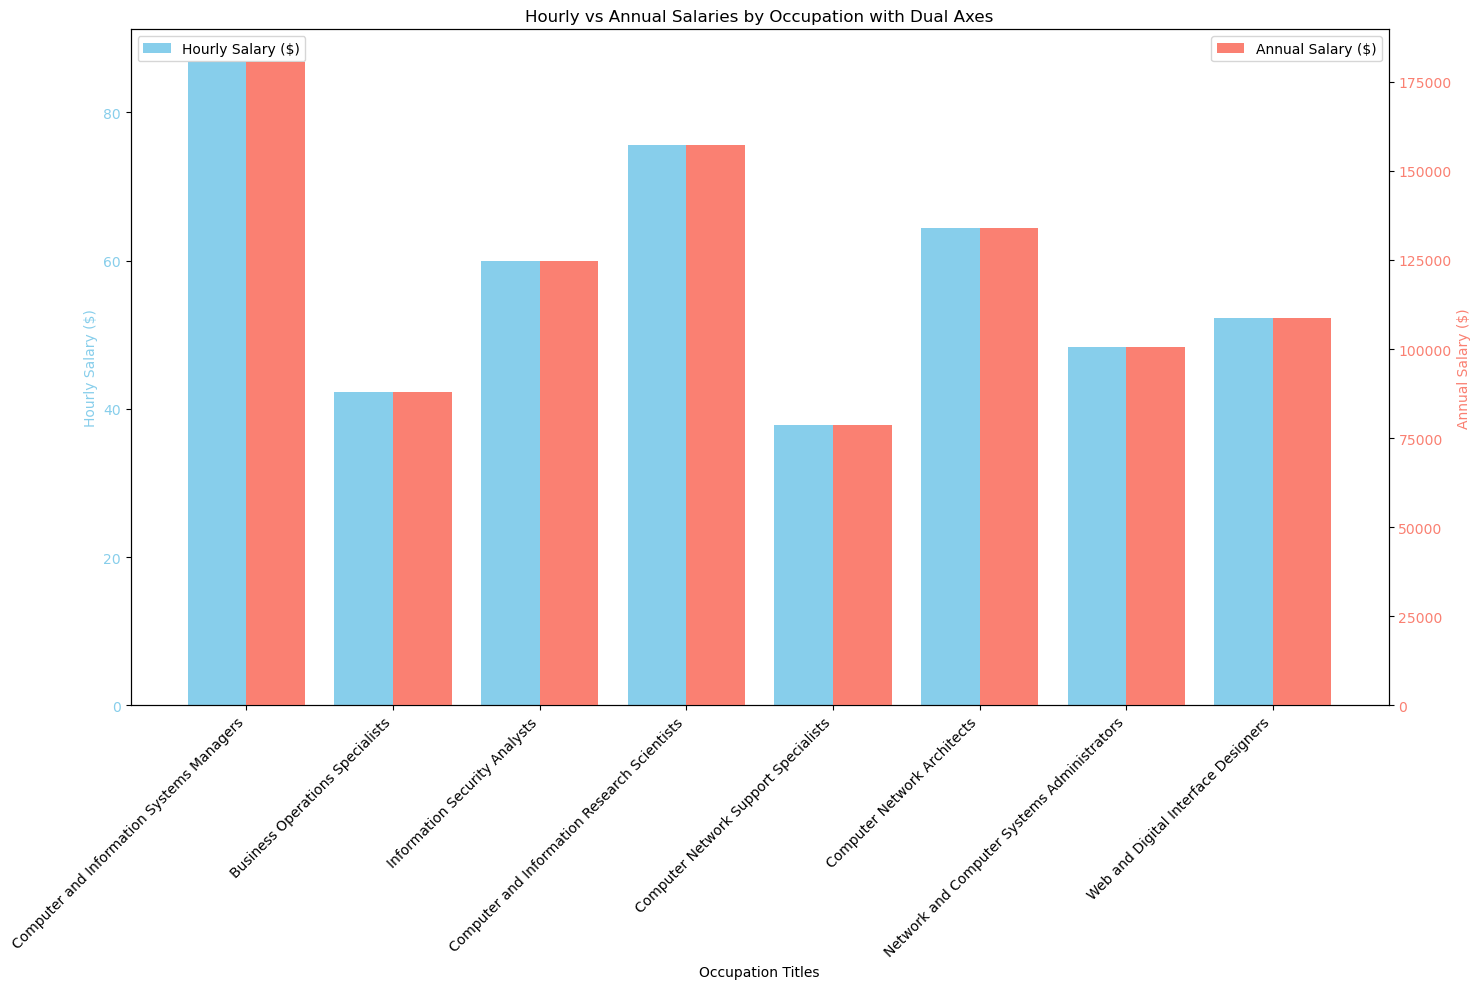

In [62]:
print('Visualization Chart 1: ')
print('Here is the mean hourly and annual salary for different occupations in your field: ')
occs = set([title[0] for title in top_5_similar])
salary_data = data[data['OCC_TITLE'].isin(occs)].drop_duplicates(subset = ['OCC_TITLE'], keep = 'first')
hourly_sals = list(salary_data['H_MEAN'])
ann_sals = list(salary_data['A_MEAN'])
occ_titles = list(salary_data['OCC_TITLE'])

# Set up the x positions for the bars
x = np.arange(len(occ_titles))

# Create the figure and axes
fig, ax1 = plt.subplots(figsize=(15, 10))

# Plot hourly salary on the first axis
bar_width = 0.4
bars1 = ax1.bar(x - bar_width/2, hourly_sals, width=bar_width, label='Hourly Salary ($)', color='skyblue')
ax1.set_xlabel('Occupation Titles')
ax1.set_ylabel('Hourly Salary ($)', color='skyblue')
ax1.tick_params(axis='y', labelcolor='skyblue')
ax1.set_xticks(x)  # Set the positions of the ticks
ax1.set_xticklabels(occ_titles, rotation=45, ha='right')  # Set the labels and rotate them


# Create a second y-axis for annual salary
ax2 = ax1.twinx()
bars2 = ax2.bar(x + bar_width/2, ann_sals, width=bar_width, label='Annual Salary ($)', color='salmon')
ax2.set_xlabel('Occupation Titles')
ax2.set_ylabel('Annual Salary ($)', color='salmon')
ax2.tick_params(axis='y', labelcolor='salmon')


# Add legends
ax1.legend(bars1, ['Hourly Salary ($)'], loc='upper left')
ax2.legend(bars2, ['Annual Salary ($)'], loc='upper right')

# Add title and adjust layout
plt.title('Hourly vs Annual Salaries by Occupation with Dual Axes')
plt.tight_layout()

# Display the plot
plt.show()

## Creating a visualization to compare pre and post covid salaries

Visualization Chart 2: 
Here is how the salaries have changed for those titles prev-covid to post-covid
[86.88, 42.33, 59.97, 75.56, 37.81, 64.39, 48.36, 52.32]
The following occupations were not present pre-covid according to BLS data: 
Title:  Web and Digital Interface Designers
Mean hourly pay for the occupation: 52.32


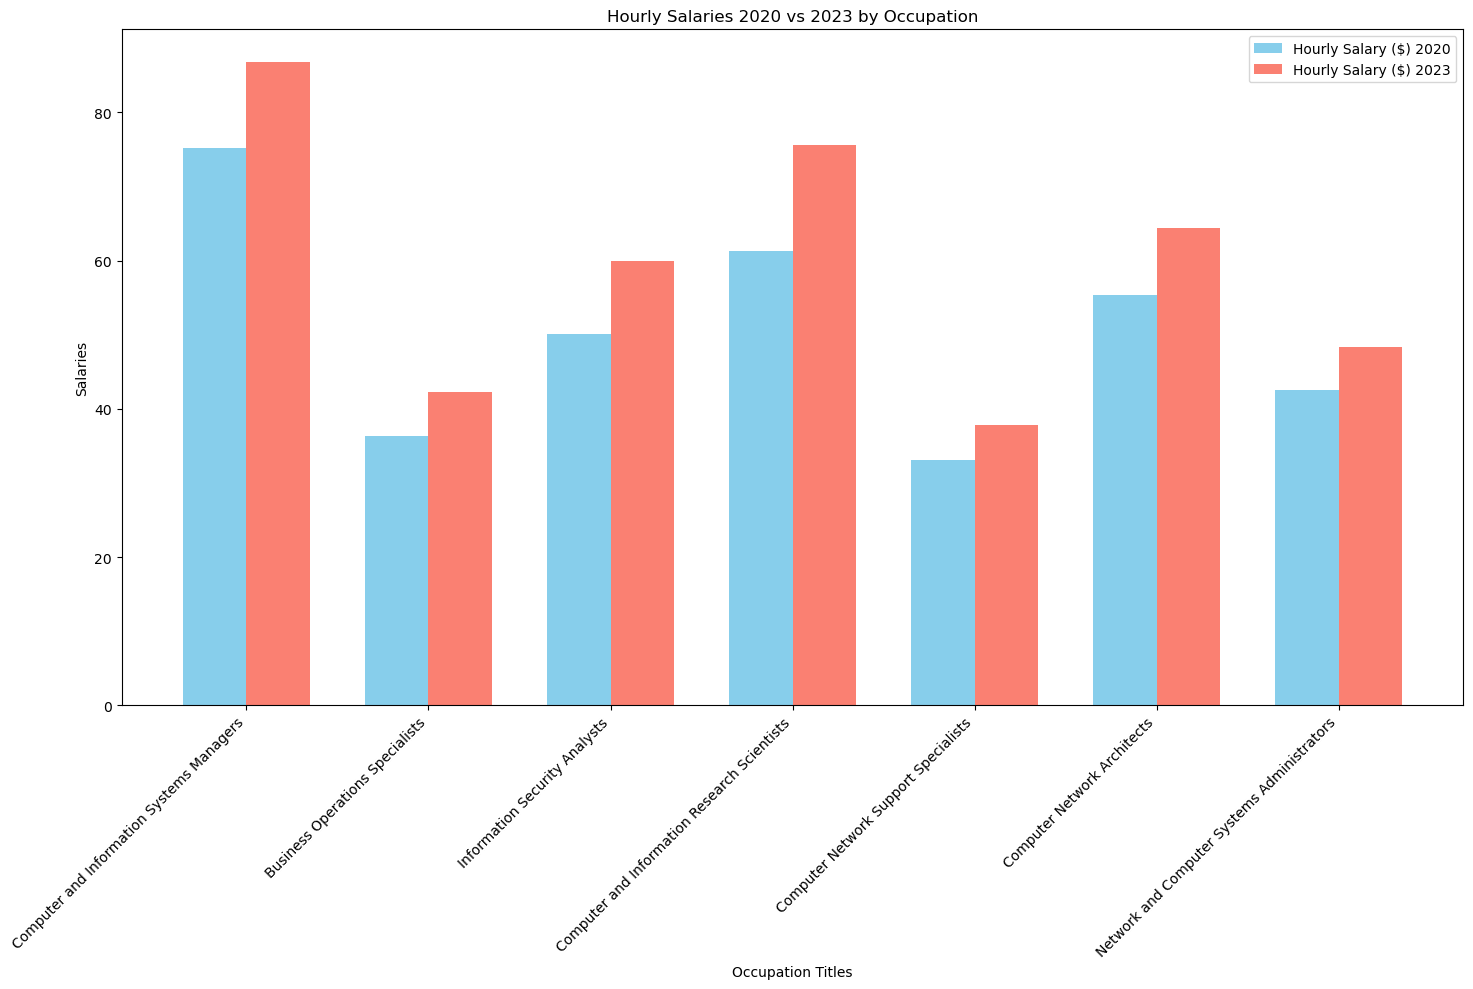

In [63]:
print('Visualization Chart 2: ')
print('Here is how the salaries have changed for those titles prev-covid to post-covid')
salary_data_2020 = data_2020[data_2020['occ_title'].isin(occs)].drop_duplicates(subset = ['occ_title'], keep = 'first')
hourly_sals_2020 = list(salary_data_2020['h_mean'])
occ_titles_2020 = list(salary_data_2020['occ_title'])
print(hourly_sals)

for i in range(len(occ_titles)):
    if occ_titles[i] not in occ_titles_2020:
        print("The following occupations were not present pre-covid according to BLS data: ")
        print("Title: ", occ_titles[i])
        print("Mean hourly pay for the occupation:", hourly_sals[i])
        hourly_sals.pop(i)
    


# Set up the bar width and positions
x = np.arange(len(occ_titles_2020))  # Positions for the bars
bar_width = 0.35  # Width of each bar

# Create the bar plot
plt.figure(figsize=(15, 10))  # Set figure size
plt.bar(x - bar_width/2, hourly_sals_2020, width=bar_width, label='Hourly Salary ($) 2020', color='skyblue')
plt.bar(x + bar_width/2, hourly_sals, width=bar_width, label='Hourly Salary ($) 2023', color='salmon')

# Add labels and title
plt.xlabel('Occupation Titles')
plt.ylabel('Salaries')
plt.title('Hourly Salaries 2020 vs 2023 by Occupation')
plt.xticks(x, occ_titles_2020, rotation=45, ha='right')  # Rotate x-axis labels for readability
plt.legend()

# Display the plot
plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()